In [1]:
import torchaudio
import torch
import speechbrain as sb
from speechbrain.inference import SpeakerRecognition
import os


INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


In [2]:
data_folder = "17paras"  # Folder where your speaker subfolders exist

# List all speaker directories
speakers = os.listdir(data_folder)
print("Detected speakers:", speakers)


Detected speakers: ['.ipynb_checkpoints', 'aditya', 'deepak', 'harika', 'keerthi', 'kushi', 'likith', 'likta', 'macha', 'maimuna', 'manasa', 'maniteja', 'muj', 'nihar', 'nikith', 'pavan', 'Rahjr', 'rahul', 'rajesh', 'rno1', 'ruk', 'sameer', 'satwik', 'sowmya', 'sup', 'vaishnavi', 'vanaja', 'vara', 'Vedpriya', 'vijetha', 'viv']


In [3]:
dataset_path = "17paras"

# Get list of speakers (folder names)
speakers = sorted(os.listdir(dataset_path))
speaker_to_id = {spk: i for i, spk in enumerate(speakers)}

# Load all data
data = []
labels = []

for speaker in speakers:
    speaker_folder = os.path.join(dataset_path, speaker)
    for filename in os.listdir(speaker_folder):
        if filename.endswith(".wav"):
            filepath = os.path.join(speaker_folder, filename)
            data.append(filepath)
            labels.append(speaker_to_id[speaker])

# Convert labels to tensor
labels = torch.tensor(labels)
print(f"Loaded {len(data)} audio files from {len(speakers)} speakers.")


Loaded 1040 audio files from 31 speakers.


In [4]:
import torch
from speechbrain.inference import EncoderClassifier
import torchaudio

# Load the pre-trained ECAPA-TDNN model
classifier = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="speechbrain_pretrained"
)

def extract_embeddings(file):
    """Extract ECAPA-TDNN embeddings and ensure consistent shape."""
    signal = classifier.load_audio(file)  # Load the audio
    embeddings = classifier.encode_batch(signal).detach()  # Get embeddings

    # Ensure shape is always [1, 192]
    embeddings = embeddings.squeeze(0)  # Remove batch dim
    if embeddings.dim() == 1:
        embeddings = embeddings.unsqueeze(0)  # Ensure (1, 192)

    return embeddings


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
C:\Users\DEEPAK\anaconda3\Lib\site-packages\speechbrain\utils\fetching.py:151: UserWarning: Using SYMLINK strategy on Windows for fetching potentially requires elevated privileges and is not recommended. See `LocalStrategy` documentation.
  warnings.warn(
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
C:\Users\DEEPAK\anaconda3\Lib\site-packages\speechbrain\utils\autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
C:\Users\DEEPAK\anaconda3\Lib\site-packages\speechbrain\utils\parameter_transfer.py:234: UserWarning: Requested Pretrainer collection using symlinks on Windows. This might not work; see `Loc

In [5]:
# Extract features with consistent shape
X = [extract_embeddings(file) for file in data]
X = torch.cat(X, dim=0)  # Concatenate correctly
y = labels.clone().detach()

print("X Shape:", X.shape)  # Should be (num_samples, 192)
print("y Shape:", y.shape)  # Should be (num_samples,)


X Shape: torch.Size([1040, 192])
y Shape: torch.Size([1040])


In [6]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Create dataset & dataloader
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define classifier
class SpeakerClassifier(nn.Module):
    def __init__(self, input_size=192, num_classes=len(speakers)):
        super(SpeakerClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# Initialize model, loss, optimizer
model = SpeakerClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the classifier
for epoch in range(30):  # 20 epochs
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


C:\Users\DEEPAK\anaconda3\Lib\inspect.py:992: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):


Epoch 1, Loss: 74.4248
Epoch 2, Loss: 2.3297
Epoch 3, Loss: 0.4059
Epoch 4, Loss: 0.1828
Epoch 5, Loss: 0.1176
Epoch 6, Loss: 0.0871
Epoch 7, Loss: 0.0684
Epoch 8, Loss: 0.0548
Epoch 9, Loss: 0.0454
Epoch 10, Loss: 0.0381
Epoch 11, Loss: 0.0324
Epoch 12, Loss: 0.0281
Epoch 13, Loss: 0.0244
Epoch 14, Loss: 0.0215
Epoch 15, Loss: 0.0191
Epoch 16, Loss: 0.0170
Epoch 17, Loss: 0.0153
Epoch 18, Loss: 0.0138
Epoch 19, Loss: 0.0125
Epoch 20, Loss: 0.0114
Epoch 21, Loss: 0.0104
Epoch 22, Loss: 0.0095
Epoch 23, Loss: 0.0088
Epoch 24, Loss: 0.0081
Epoch 25, Loss: 0.0075
Epoch 26, Loss: 0.0069
Epoch 27, Loss: 0.0064
Epoch 28, Loss: 0.0060
Epoch 29, Loss: 0.0056
Epoch 30, Loss: 0.0052


In [7]:
def predict_speaker(model, classifier, audio_path):
    # Extract embedding
    embedding = extract_embeddings(audio_path) # Pass only the audio_path
    print("Embedding Shape:", embedding.shape)  # Expected (192,) or (256,)

    # Ensure embedding is in the correct format
    embedding = embedding.unsqueeze(0)  # Shape should be (1, 192) or (1, 256)
    print("Reshaped Embedding Shape:", embedding.shape)

    # Get model output
    with torch.no_grad():
        output = model(embedding)
        print("Model Output Shape:", output.shape)  # Expected (1, num_speakers)

    # Debug: Print full output tensor
    print("Model Raw Output:", output)

    # Get the predicted label
    pred_label = torch.argmax(output, dim=-1).item()
    print("Predicted Label Index:", pred_label)

    # Check if pred_label is valid
    if pred_label >= len(speakers):
        print("Error: Predicted label out of range!")
        return "Unknown"

    return speakers[pred_label]

In [8]:
test_audio = "17paras/likith/lik_1.wav"
predicted_speaker = predict_speaker(model, classifier, test_audio)
print(f"Predicted Speaker: {predicted_speaker}")

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -1.4180,   1.9980, -11.4667,   2.6209,  -2.2128,  -3.5498,  -3.3350,
           -4.4633,  12.8519,   0.6957,  -6.2660,  -3.6521,  -3.1849,   1.0233,
           -0.3749,  -0.9378,   4.0223,   4.5099,   0.0320,  -5.7448,  -4.2293,
           -1.4854,  -0.3195,   0.5488,  -9.1188,  -5.3191,  -2.9329,  -3.2043,
           -7.9435,  -3.1218,  -1.3229]]])
Predicted Label Index: 8
Predicted Speaker: likith


Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -9.3386,  -3.9323,  -7.5160,  -2.7385,   3.0245, -11.4265,  -8.9808,
           -3.8196,   3.4573,  -4.7615,  -4.8910,  -4.7443,  -2.4854,  -0.5680,
           -7.9738,   2.1438,  -1.6517,   1.3835,   4.9336,   9.4890,  -3.6199,
           -4.5287,  -1.1009,   0.8783,  -3.8399, -11.4780,  -7.0371,  -0.1134,
          -12.5516,  -5.2888,  -1.6716]]])
Predicted Label Index: 19
Predicted Speaker: rajesh


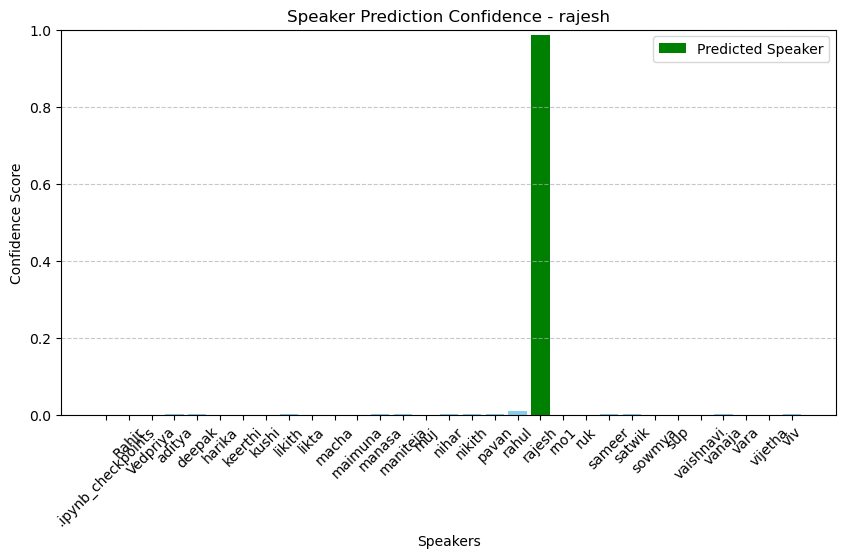

In [9]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Call the existing function
test_audio = "test/newraj.wav"
predicted_speaker = predict_speaker(model, classifier, test_audio)
print(f"Predicted Speaker: {predicted_speaker}")

# Get model output again for confidence scores
with torch.no_grad():
    embedding = extract_embeddings(test_audio).unsqueeze(0)  # Ensure correct shape
    output = model(embedding)

# Apply softmax to convert logits into probabilities
softmax_probs = F.softmax(output, dim=-1).squeeze()  # Remove extra dimensions if needed
softmax_probs = softmax_probs.cpu().numpy()  # Convert only after calling .cpu()

# Plot confidence scores
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(speakers)), softmax_probs, color='skyblue')
plt.xticks(np.arange(len(speakers)), speakers, rotation=45)
plt.ylabel("Confidence Score")
plt.xlabel("Speakers")
plt.title(f"Speaker Prediction Confidence - {predicted_speaker}")
plt.ylim(0, 1)  # Confidence scores range from 0 to 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Highlight the predicted speaker
pred_label = np.argmax(softmax_probs)
plt.bar(pred_label, softmax_probs[pred_label], color='green', label="Predicted Speaker")
plt.legend()

# Show the plot
plt.show()


In [10]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="tr1.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("tr1.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "tr1.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-7.1770, -5.3567, -6.6134, -0.2924, -1.1527, -7.5616, -2.0394,
          -6.2847, -1.8952, -1.2611,  0.7536, -1.5546, -5.9366,  2.1746,
          -2.7589, -0.8565, -0.9316,  3.1373,  0.2260,  7.6761, -4.3410,
          -5.3026, -3.1019,  0.7190, -6.5600, -6.1283, -2.3074, -4.7816,
          -7.7119, -4.3154,  1.5489]]])
Predicted Label Index: 19
Predicted Speaker: rajesh


In [11]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="td1.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("td1.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "td1.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-9.5492,  0.3859, -5.1294,  0.1753,  9.7215, -1.1121, -1.7589,
          -7.5972, -3.1711, -5.9376,  6.4023, -1.6054, -3.5699,  1.8626,
          -1.6932,  0.5343,  2.1549, -2.1190, -2.2653, -3.6833, -3.5423,
           1.0851,  0.3609,  1.6199, -7.0319, -9.6235, -6.6140,  0.7710,
          -3.8603, -2.4875, -1.9732]]])
Predicted Label Index: 4
Predicted Speaker: deepak


In [12]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="trh1.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("trh1.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "trh1.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-10.2038,  -4.8244,  -2.1009,  -2.8796,  -0.3603,  -3.3834,  -2.0663,
           -2.5674,  -2.1898,  -2.0208,   0.0668,   0.3581,   0.6070,  -1.0402,
           -0.0732,   0.2683,  -0.7376,  -4.6355,   0.7074,  -3.2597,   0.3179,
           -1.1452,   0.1868,   1.7131,  -6.1788,  -6.6522,   3.7869,   3.5006,
           -4.5333,  -2.1100,  -4.2423]]])
Predicted Label Index: 26
Predicted Speaker: vaishnavi


In [13]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="trh2.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("trh2.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "trh2.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-8.6998,  1.1555, -4.9792,  2.1053,  1.2977, -1.2546, -1.3430,
          -0.3111, -1.5143, -3.3618,  1.9836, -2.1934, -4.6328, -0.7835,
          -4.1464,  2.3813, -2.9315, -0.2301,  0.4233, -3.9080, -2.0520,
          -4.1006,  0.7371, -0.2909, -3.6535, -8.0335, -1.2920,  3.2498,
          -6.4049, -8.5462, -2.0648]]])
Predicted Label Index: 27
Predicted Speaker: vanaja



🔍 Predicted Speaker: vijetha (Confidence: 0.8293)

📊 Confidence Scores for Each Speaker:
.ipynb_checkpoints: 0.0000
Rahjr: 0.0000
Vedpriya: 0.0000
aditya: 0.0000
deepak: 0.0000
harika: 0.0000
keerthi: 0.0001
kushi: 0.0000
likith: 0.0000
likta: 0.0174
macha: 0.0000
maimuna: 0.0002
manasa: 0.0000
maniteja: 0.0000
muj: 0.0000
nihar: 0.0000
nikith: 0.0000
pavan: 0.0000
rahul: 0.0000
rajesh: 0.0000
rno1: 0.0000
ruk: 0.0000
sameer: 0.0000
satwik: 0.0000
sowmya: 0.0000
sup: 0.0000
vaishnavi: 0.0000
vanaja: 0.1515
vara: 0.0014
vijetha: 0.8293
viv: 0.0000


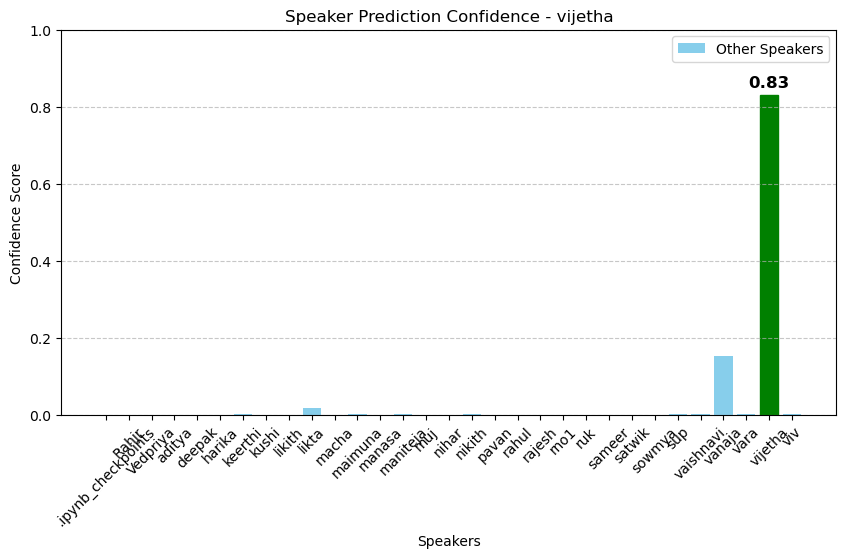

In [13]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Define a threshold for unknown speakers
UNKNOWN_THRESHOLD = 0.5  # Adjust based on performance

def predict_speaker_with_confidence(model, classifier, audio_path):
    """Predict speaker with confidence score comparison."""
    embedding = extract_embeddings(audio_path).unsqueeze(0)  # Ensure correct shape

    with torch.no_grad():
        output = model(embedding)

    # Apply softmax for confidence scores
    softmax_probs = F.softmax(output, dim=-1).squeeze().cpu().numpy()

    # Get the most confident prediction
    pred_label = np.argmax(softmax_probs)
    confidence = softmax_probs[pred_label]

    # Handle unknown speakers
    if confidence < UNKNOWN_THRESHOLD:
        predicted_speaker = "Unknown"
    else:
        predicted_speaker = speakers[pred_label]

    print(f"\n🔍 Predicted Speaker: {predicted_speaker} (Confidence: {confidence:.4f})")

    # Print all confidence scores
    print("\n📊 Confidence Scores for Each Speaker:")
    for i, speaker in enumerate(speakers):
        print(f"{speaker}: {softmax_probs[i]:.4f}")

    # Plot confidence scores
    plt.figure(figsize=(10, 5))
    bars = plt.bar(np.arange(len(speakers)), softmax_probs, color='skyblue')
    plt.xticks(np.arange(len(speakers)), speakers, rotation=45)
    plt.ylabel("Confidence Score")
    plt.xlabel("Speakers")
    plt.title(f"Speaker Prediction Confidence - {predicted_speaker}")
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Highlight the predicted speaker
    if predicted_speaker != "Unknown":
        bars[pred_label].set_color('green')  # Change color to green
        plt.text(pred_label, softmax_probs[pred_label] + 0.02, f"{confidence:.2f}",
                 ha='center', fontsize=12, fontweight='bold')

    plt.legend(["Other Speakers", "Predicted Speaker"], loc="upper right")
    plt.show()

    return predicted_speaker, confidence

# Test with an audio file
test_audio = "vt1.wav"
predicted_speaker, confidence = predict_speaker_with_confidence(model, classifier, test_audio)



In [18]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="tl1.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("tl1.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "tl1.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-8.2280, -1.9300, -2.6635,  0.3641, -3.4957, -2.7442,  3.4729,
           0.8973, -2.4847, -2.9988,  1.4492, -5.0852,  1.2950,  1.2440,
          -4.1365,  0.5550, -3.0140, -3.9738,  1.4322, -4.0086, -2.1082,
          -4.0379,  2.2392,  2.5207, -3.5359, -6.5269,  2.3158,  1.4001,
          -4.3861, -5.1045, -1.5922]]])
Predicted Label Index: 6
Predicted Speaker: keerthi


In [19]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="tl2.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("tl2.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "tl2.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-15.4158,   6.8335,  -6.4717,  -0.5373,   5.5550,  -3.7093,  -1.8458,
           -6.1415,   3.4317,  -0.0547,  -3.6876,  -3.9651, -10.3188,  -2.3908,
           -3.8134,   4.4628,  -3.4347,  -1.1075,  -6.5721,  -7.6241,  -5.9424,
           -3.7882,  -1.7979,  -1.8645,  -4.6830,  -8.6604,  -6.2837,   1.9438,
           -7.6088,  -9.5800,  -2.6658]]])
Predicted Label Index: 1
Predicted Speaker: Rahjr


In [21]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="tr3.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("tr3.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "tr3.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-7.8441, -5.2420, -6.7834, -1.0204,  4.4261, -5.0854, -3.2675,
          -5.9546,  0.0549, -4.2513,  4.4620, -1.6829, -7.1718, -1.6762,
          -4.4741, -2.3498,  4.1212,  3.0513,  0.4710,  3.4979, -4.5774,
          -7.3114, -1.0149,  2.7228, -8.4311, -5.9176, -0.9185, -2.6206,
          -5.7182, -5.3219, -5.7740]]])
Predicted Label Index: 10
Predicted Speaker: macha


In [22]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="tr4.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("tr4.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "tr4.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-4.7278,  0.4226, -4.3930, -0.3213,  1.3806, -3.1375,  0.3334,
          -4.3596,  0.4252, -1.3847,  0.2392, -2.5964, -3.1011,  1.5765,
          -3.6482, -1.6117, -2.6221,  1.6072, -1.6127,  4.7209, -1.7261,
          -1.6385, -2.0188,  0.8955, -0.8142, -5.7910, -5.8909, -1.1214,
          -6.3896, -1.3691,  4.8205]]])
Predicted Label Index: 30
Predicted Speaker: viv


In [23]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="tr5.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("tr5.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "tr5.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -5.1620,  -2.9123,  -4.6836,  -1.6152,   2.2629,  -8.8590,  -3.9789,
           -3.8503,   2.9701,  -1.2687,  -0.9131,  -5.2121,  -0.3682,  -0.6909,
           -5.3477,  -5.4488,  -0.7022,   0.4854,  -0.9916,   9.7593,  -3.1528,
           -3.8032,  -3.4082,   3.7708,  -3.6592,  -9.0341,  -7.1278,  -1.2188,
          -10.5334,  -2.1907,   2.9607]]])
Predicted Label Index: 19
Predicted Speaker: rajesh


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-11.6537,  13.0574,  -2.9597,   5.8236,   1.5467,  -1.5519,  -3.1173,
           -1.8326,   1.1899,  -1.0029,  -3.0536,  -3.2223,  -1.4887,  -0.2916,
           -2.6337,  -1.9264,  -6.5764,   3.5437,  -1.4438,  -1.2726,  -2.5540,
            1.6570,  -5.7393,   2.0258,   0.5209,  -3.8159, -11.8179,   0.3825,
           -7.4448,  -1.4772,   2.0497]]])
Predicted Label Index: 1
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-15.0942,  16.0123,  -3.1764,   8.0671,   1.8391,   3.1141,   1.2457,
           -3.1204,   1.7801,  -0.2068,  -1.0601,  -5.5895,  -5.8104,   4.0325,
           -8.2095,  -0.9126,  -9.4142,   3.2752,  -4.9019,  -4.6037,  -1.1951,
            0.1259,  -2.9257,   2.8363,   2.1304,  -2.7971,  -8.5232,   0.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-16.0178,  14.1418,  -1.5192,   0.0851,  -0.7331,  -3.5505,   0.9995,
           -3.7664,   5.6328,  -0.2524,  -6.3240,  -4.3521,  -3.5004,  -0.9741,
           -0.2566,  -3.7108,  -6.7968,  -1.2647,  -4.4157,  -2.0505,  -0.2185,
           -1.4034,  -6.7947,   1.5982,   1.0295,   0.2237,  -8.3185,  -3.3998,
           -1.6950,  -3.1270,   1.7300]]])
Predicted Label Index: 1
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-20.9627,  18.6847,  -3.5628,   3.8001,   2.3466,  -1.7166,   1.4903,
           -3.9564,   6.1837,  -2.0824,  -3.7454,  -2.5200,  -4.1369,   0.6393,
           -4.2044,  -2.1116, -11.7809,  -0.9487,  -4.2541,  -2.8740,  -2.4241,
            0.2630,  -7.5794,   4.9098,   2.1425,  -1.0388, -11.9749,  -2.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-17.7229,  15.9983,  -1.2455,   5.5371,  -2.3063,   1.3443,   1.7836,
           -7.6638,  -0.7324,  -3.6032,  -3.8158,  -2.8720,  -8.8495,   3.7001,
           -0.7336,  -3.8730,  -9.2850,  -3.4787,  -7.3534,  -3.1353,   1.3069,
           -0.8478,  -1.5686,   0.5286,   1.4241,  -3.8605, -11.4161,  -2.4166,
            0.3674,  -1.8236,   4.4802]]])
Predicted Label Index: 1
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-22.1207,   3.4061,  18.8683,   1.4132,  -3.8609,  -4.4332,   4.6877,
            8.5781,  -7.3721, -10.6767,  -8.9551,   7.6661,  -6.1017,   3.4069,
           -3.8085,  -5.7036, -10.7189, -13.8969,   1.9037,  -1.5724,  -3.4749,
            0.1762,  -9.8215,  -3.5864,   5.2395,  -3.7291,  -6.8609,   3.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-21.5235,  -1.0830,  18.1053,   1.2786,  -5.6640,  -4.1909,   6.9139,
            5.9086, -10.3337,  -8.5222,  -5.5284,   6.1220,  -8.0501,   0.4195,
            1.7062,  -3.2440,  -7.6571,  -9.9676,   1.6604,  -3.4824,  -5.2727,
            4.5325, -10.0926,  -3.6623,   0.2895,  -0.0918,  -5.9464,  -0.5133,
           -0.1645,  -1.1653,  -5.1370]]])
Predicted Label Index: 2
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-24.7422,   0.4943,  18.6882,   4.1235,  -3.7842,  -5.2974,   3.9534,
            3.6119,  -8.0310, -12.6516, -10.9656,   8.6467,  -7.5860,  -1.1352,
           -0.2082,  -4.6700,  -7.5018, -13.6359,  -0.4072,  -2.6950,  -3.4738,
            2.6333,  -7.1745,  -1.5846,  -5.7739,  -3.3708,  -8.2265,   2.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-19.2833,   2.4261,  21.6883,   3.2391,  -0.8385,  -2.3897,   3.3442,
            7.5592,  -7.4729,  -7.0667,  -7.9357,   4.5942,  -5.5112,  -3.5906,
           -1.5565, -10.2892,  -2.9203,  -4.7854,   2.1809,  -2.2528,  -3.5356,
            2.5281, -11.3082,   2.9570,  -1.0803,   4.5744,  -7.7252,   2.0376,
           -2.6565,  -2.8663,  -6.9674]]])
Predicted Label Index: 2
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-21.7720,   2.0603,  20.1366,  -0.1821,  -6.6345,  -3.0143,   4.6839,
           10.3615,  -8.6394,  -8.6487,  -7.6814,   6.1598,  -6.4654,   2.6715,
           -2.0676,  -6.4035,  -8.9298, -11.6777,   3.1458,  -3.8913,  -4.5485,
            1.8996, -10.4840,  -4.3111,   6.3157,  -3.6253,  -4.7664,   1.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-17.2940,   3.8593,  -6.0234,  13.8121,  -1.1921,  -1.6746,  -5.5307,
           -7.2790,  -3.3927,  -3.9384,  -3.8143,  -2.5201,  -9.0509,   1.1029,
           -4.4556,   2.5649,  -5.3402,   3.8767,  -3.8817,  -0.1317,  -1.0887,
           -1.3557,  -1.1343,  -2.5156,  -5.9655, -10.2144, -12.0117,  -3.6173,
           -5.1870,  -6.8529,  -2.0942]]])
Predicted Label Index: 3
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-17.4841,   4.6610,  -0.9801,  13.3777,   1.9817,   0.8010,  -2.3163,
           -8.4800,  -6.0979,  -4.6915,  -1.7836,   1.6300,  -7.2928,   1.4692,
           -0.8004,  -0.5975,  -3.9755,   1.6381,  -2.9454,  -0.3345,  -2.0781,
            4.1168,  -1.7761,  -3.8659,  -6.2543,  -7.8635, -12.4838,  -3.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-19.5666,   5.4566,  -2.8551,  17.2942,   0.3822,   1.0852,  -3.2500,
           -8.1822,  -7.1800,  -3.9770,  -1.1909,   0.1752,  -7.2284,   2.9157,
           -3.4162,   2.9858,  -7.3677,   4.3428,  -1.5611,  -0.3028,  -2.4052,
            1.8695,  -3.6872,  -0.4681,  -6.0123,  -7.2897, -12.1056,  -3.2009,
           -5.4122,  -6.0879,   2.0920]]])
Predicted Label Index: 3
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-17.1356,   3.4958,   0.2695,  11.4781,   2.9063,  -1.2238,  -3.0031,
           -7.9144,  -3.6695,  -4.6651,  -4.9418,   2.8202,  -5.2364,  -0.7916,
           -0.1377,  -1.0694,  -2.6193,  -1.1490,  -2.6724,   1.8761,  -1.8765,
            1.7032,  -3.5336,  -1.3045,  -6.5940,  -5.4268, -11.8849,  -0.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -8.2843,  -4.6359,  -8.8027,  -1.7481,  11.5565,  -6.4546,  -4.8404,
           -5.6938,  -0.4280,  -6.1940,   3.9357,  -3.9004,  -5.9138,  -0.4597,
           -4.8575,   0.2762,   1.9435,   1.5926,   0.4738,   2.4485,  -3.3665,
           -4.0523,  -0.6860,   0.1906,  -9.2468, -12.1385,  -5.6185,   0.9428,
           -8.2477,  -2.2638,  -2.2574]]])
Predicted Label Index: 4
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-9.4854,  1.6758, -3.9606, -1.5326, 13.3266, -5.9408, -1.2698,
          -4.1585,  2.5120, -3.8528,  1.1472, -0.7067, -2.2000,  0.1731,
          -3.7558, -2.0552, -0.8331, -1.4681,  0.6624,  1.8604, -4.3983,
          -1.4923, -3.8927,  3.9104, -7.5655, -8.4995, -5.7038,  2.9999,
          -4.3912, -3.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -9.0667,  -1.8134,  -4.4192,  -4.3719,  16.5627,  -6.8940,  -2.9435,
           -5.3356,  -0.5952,  -7.1769,   2.0925,  -2.7495,  -2.0875,  -3.1673,
           -5.0650,  -3.4508,   4.2056,  -2.2283,   0.2729,   2.3054,  -4.4077,
           -0.8997,  -2.6767,   3.1565,  -9.1081, -11.4783,  -6.1984,   3.7209,
           -7.0967,  -2.0836,  -3.3136]]])
Predicted Label Index: 4
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-11.5171,   0.4697,  -2.6104,  -3.2765,  17.7030,  -5.0334,  -3.2539,
           -6.2778,  -1.9267,  -7.6829,   1.4559,  -2.0014,  -3.6213,  -3.6892,
           -3.7522,  -3.0138,   4.4846,  -2.0163,  -0.9769,  -0.7237,  -4.9340,
           -0.4457,  -3.4193,   4.1720,  -9.7176, -10.1738,  -6.4939,   4.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-18.9711,  -1.1386,  -0.9351,   1.6960,   0.3683,  14.9470,   1.2508,
           -6.2303,  -8.3988,  -5.3235,  -0.8264,   0.6967,  -0.3736,   0.6482,
            1.2705,  -5.7925,  -7.4538,  -9.4410,  -4.6126,  -8.4937,   2.8537,
           -1.7870,  -0.9596,   1.7275,  -0.1961,  -0.2932,  -4.7384,   5.1119,
            1.9072,   2.3373,  -7.1812]]])
Predicted Label Index: 5
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-20.5786,  -1.7857,  -0.6026,   3.3942,   0.7277,  15.9886,   1.9338,
           -6.3020,  -9.5314,  -6.9289,   0.2264,   1.0186,  -1.0052,   1.6212,
            0.7073,  -7.2088,  -8.1801, -10.2327,  -5.0151,  -8.7781,   3.2448,
           -0.1933,  -1.7350,   2.1097,  -1.1870,  -0.2506,  -8.5026,   2.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-19.4558,   2.4182,   0.2225,   3.4167,   1.0830,  15.3968,   1.4841,
           -4.8084,  -8.1525,  -2.0670,  -0.8873,  -0.6524,  -4.9914,   1.4750,
            0.1847,  -2.1797, -10.3249,  -7.6826,  -6.0609,  -7.9416,  -0.6552,
           -2.3490,  -2.4162,   0.6117,   0.0529,   0.6257,  -7.7391,   5.3315,
           -0.8914,   0.2628,  -3.6918]]])
Predicted Label Index: 5
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-24.0421,  -0.6380,  -0.4152,   4.0159,  -0.1779,  17.7217,   1.7157,
           -5.7949, -10.4842,  -4.0521,  -1.2980,   0.2572,  -3.1034,  -0.2140,
            2.2266,  -6.1409, -10.7027,  -9.3155,  -5.7409,  -7.9079,   1.2399,
           -1.7886,  -2.7770,   1.8253,  -1.8167,   0.4250,  -9.6544,   4.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-21.2758,  -3.1499,   3.7378,  -4.3787,  -3.7376,   1.5723,  14.2911,
           -0.0983,  -8.3500,  -0.5727,  -3.5723,   1.3747,  -7.2276,  -2.0070,
           -2.0467,  -6.0459,  -9.5998,  -8.7128,  -6.0155,  -8.8712,  -4.2039,
            1.4926,  -7.4244,  -6.1857,  -2.7107,   4.5838,   1.7341,   0.1245,
            2.1392,  -2.3563,  -6.7817]]])
Predicted Label Index: 6
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-16.6752,  -2.6387,   5.7837,  -6.4407,  -0.6818,  -2.0823,  16.7524,
            2.7514,  -4.9079,  -1.6138,  -0.8469,  -1.4263,  -6.9195,  -3.2855,
            0.4835,  -4.1128,  -6.1835,  -8.6496,  -3.3125,  -7.9854,  -5.0833,
           -0.4730,  -7.6776,  -2.9533,  -3.3161,   3.8959,   2.7018,  -1.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-20.9227,  -0.6575,   4.4986,  -0.9061,  -5.0123,   2.8302,  15.4448,
            1.0618,  -6.4119,  -3.8555,  -2.2761,   1.6209,  -7.7230,  -0.9191,
            2.3422,  -6.8823,  -8.5009, -10.7620,  -3.9077,  -8.1078,  -1.1926,
           -3.6058,  -5.7562,  -2.9657,  -3.3885,   4.6740,  -2.7085,  -2.3459,
            3.5773,  -4.8650,  -6.6302]]])
Predicted Label Index: 6
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-18.2940,  -2.0291,  -2.4918,  -5.1631,  -2.1268,   2.9971,  11.9997,
           -1.3949,  -5.2725,   3.5756,  -6.0767,  -1.5656,  -3.3574,   0.1486,
           -0.0894,  -6.8014,  -4.7233,  -7.6116,  -6.2052,  -7.7905,  -0.5152,
           -1.3978,  -3.3849,  -4.0295,  -5.3289,  -2.5896,   4.0567,   2.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-10.5806,  -2.3271,   3.3768,  -6.3729,  -3.2534,  -3.5995,   3.9546,
           15.9659,   0.6595,  -1.7253,  -2.8198,  -2.1701,   1.9396,  -3.6200,
           -6.4072,  -9.2031,  -3.2800,  -6.2481,   4.0611,  -3.2867,   0.1216,
           -2.5114,  -7.2861,  -2.8959,   4.0214,  -0.1900,  -4.1618,   5.0091,
          -10.0731,  -3.4413,  -5.9480]]])
Predicted Label Index: 7
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-7.7708, -2.6179,  2.7746, -0.7047, -3.3027, -2.7357,  1.3560,
          13.4745, -2.8267,  1.3015, -3.1131, -3.3976,  3.9106, -1.6380,
          -2.2734, -9.5326, -3.4477, -1.6632,  3.4742, -0.8424,  4.3913,
          -2.7859, -6.7533, -1.1630,  0.4930, -3.3814, -0.7300,  5.8053,
          -4.7206, -3.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-13.1580,  -1.8790,   3.4681,  -5.2279,  -5.6904,  -3.3456,   2.6744,
           18.0813,  -0.2785,  -1.1627,  -6.6306,  -3.8328,   2.4916,  -0.5578,
           -3.1372,  -8.7564,  -3.2300,  -6.2648,   4.5836,  -3.8308,   1.0896,
           -1.2167,  -9.0858,  -3.8128,   4.7261,  -1.4073,  -9.2015,   3.8883,
           -7.9072,  -2.2892,  -5.7256]]])
Predicted Label Index: 7
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-10.2403,  -1.8856,   4.0694,  -2.9211,  -4.8980,  -1.8427,   2.0964,
           17.4183,  -0.4435,   0.9653,  -4.5396,  -4.9785,   2.9731,  -1.5565,
           -3.0626, -11.0453,  -2.9532,  -2.1392,   3.6298,  -3.2546,   2.4752,
           -4.1622,  -7.3358,  -0.7239,   2.1035,  -1.3878,  -3.7858,   5.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-16.9788,   1.0036,   7.0961,  -5.8453,  -8.2431,  -8.5734,   2.8251,
           18.0234,  -1.0016,  -1.9419,  -6.9195,  -1.3301,  -3.4135,  -3.5627,
           -4.1126,  -7.3948,  -9.3435,  -3.4257,   3.3877,  -0.4675,  -3.7145,
           -4.4132, -11.7770,  -0.7672,   3.7611,   2.6473,  -7.6119,   0.3791,
           -9.6396,  -2.9938,  -7.0378]]])
Predicted Label Index: 7
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-6.6269e+00,  1.2732e+00, -6.3659e+00, -6.4938e+00, -4.4683e-03,
          -1.1387e+01, -3.0801e+00,  3.4979e-01,  1.1871e+01, -1.5401e+00,
          -3.9811e+00, -6.1115e+00, -3.9650e+00, -4.0597e+00, -6.5509e+00,
          -1.1950e+00,  9.7634e-01, -2.7646e-01, -1.9924e+00, -4.9469e-01,
          -4.8

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -9.0563,   4.6745,  -5.6261,  -4.9800,   3.0420, -10.5537,  -3.0436,
           -1.5561,  14.4757,  -1.5234,  -6.5539,  -6.6137,  -4.6189,  -2.8795,
           -7.0106,   0.4781,  -2.3434,   0.8473,  -3.4173,   2.3678,  -5.9762,
           -6.3114,  -4.1329,   1.2342,  -2.6211,  -9.3439, -11.8868,   0.8437,
          -10.5686,  -7.5125,  -0.1077]]])
Predicted Label Index: 8
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -9.1665,   2.4679,  -5.6380,  -5.0979,   2.8694, -10.7509,  -3.2723,
           -0.3524,  14.1358,  -2.3764,  -4.7914,  -4.8488,  -4.9819,  -3.1359,
           -5.8976,   1.5870,  -2.2804,  -0.4916,  -2.6327,   2.5992,  -5.9170,
           -8.2574,  -4.2393,   2.7806,  -3.7851,  -9.2353,  -9.8687,   0.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-8.8756e+00, -3.4873e+00, -6.1675e+00, -9.3256e+00,  9.6131e-01,
          -1.3958e+01, -7.3209e+00,  8.6344e-01,  1.3134e+01, -2.9627e+00,
          -5.3974e+00, -8.2989e+00, -2.9469e+00, -5.9126e+00, -5.6801e+00,
          -1.9731e+00,  3.2835e+00, -8.1238e-03,  2.0767e+00,  4.9533e+00,
          -5.1431e+00, -1.0981e+01, -2.1534e+00,  5.5245e-01, -5.7681e+00,
          -1.1190e+01, -7.1056e+00,  1.0847e+00, -1.3518e+01, -4.2438e+00,
          -1.4224e+00]]])
Predicted Label Index: 8
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-6.0515,  1.6700, -6.7839, -5.4195,  3.1708, -8.4830, -4.3076,
          -1.1968, 12.6240, -1.5625, -4.2403, -5.4625, -1.6257, -1.6233,
          -4.8531,  0.4513, -0.4974,  0.8943, -0.1044, 

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-13.5439,  -4.1656,  -5.5367,  -5.6725,  -3.9949,  -1.7023,  -1.2861,
           -1.5506,  -1.7324,  15.3785,  -2.3875,  -8.9015,  -6.0066,  -0.5786,
           -2.1716,  -1.1958,  -4.0829,   5.5855,  -4.8753,  -3.1578,  -9.7735,
           -4.4234,  -7.5333,  -0.2825,  -5.5018,  -4.5018,   4.9564,  -0.1048,
           -9.0473,  -4.4123,  -1.5425]]])
Predicted Label Index: 9
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-15.4214,  -2.5805,  -3.9696,  -4.0507,  -6.3016,  -1.9854,  -0.6897,
           -2.1638,  -4.4030,  13.2115,  -4.2061,  -4.7897,  -1.5115,  -3.5699,
           -0.9692,  -6.7252,  -6.4400,   0.9900,  -6.7348,  -3.4651,  -4.9789,
           -1.9766,  -7.3478,   1.6461,  -5.6806,   0.2649,   4.2341,  -2.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-16.6408,  -5.2759,  -6.9076,  -4.2264,  -7.9368,  -1.7832,  -2.2803,
           -1.4238,  -4.0053,  11.4596,  -7.0115,  -6.1578,  -1.9748,   1.2125,
            0.4258,  -5.8938,  -5.6477,  -3.5795,  -5.6615,  -2.8880,  -5.0032,
           -4.3394,  -4.0345,  -1.0768,  -5.5657,  -3.7018,   2.1174,   0.9422,
           -4.5065,  -0.0605,  -0.5429]]])
Predicted Label Index: 9
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-10.8784,   0.2469,  -0.1216,  -2.3452,  -5.3994,  -2.1121,   0.2698,
            3.0391,  -4.0047,  10.3585,  -2.2304,  -7.0657,  -4.1294,  -4.2863,
            0.8474,  -4.3465,  -3.2248,   1.2455,  -6.7132,  -2.7012,  -6.4849,
            0.0663,  -6.1541,   0.1834,  -4.4493,  -3.3701,   2.5246,   0.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -6.2445,  -4.8069,  -8.5463,   0.0468,   8.1362,  -2.3141,  -2.5233,
           -8.0551,  -2.6066,  -7.1238,  19.0279,   3.3517,  -8.4220,   1.6411,
           -8.1199,  -0.2628,   2.3928,  -0.0606,  -3.2738,   1.7263,  -3.7723,
           -4.9852,   2.3674,   1.2086,  -8.9624, -10.5035,  -2.6912,  -0.7755,
          -11.3868,  -6.5194,  -0.9388]]])
Predicted Label Index: 10
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-7.4126, -5.6209, -6.3047, -2.0085,  6.6243, -3.3660, -2.6147,
          -6.0700, -1.8858, -4.5672, 14.9840,  1.8558, -6.5435, -1.1619,
          -5.7193, -2.5116,  4.5536,  0.1237, -2.6777,  1.2715, -5.7352,
          -5.7388,  0.2808,  3.5149, -8.9476, -8.7493, -0.8531, -2.0527,
          -9.6403, -5

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -4.1920,  -4.8411,  -8.9788,   0.5355,   0.8599,  -3.6816,  -3.6916,
           -6.2979,  -2.9742,  -3.1944,  14.5287,  -4.6068,  -6.5528,   2.1420,
           -6.3180,  -1.6088,   3.2397,   6.1852,  -5.5493,   2.7327,  -3.6644,
           -3.4005,   0.2363,  -0.1667,  -6.8551, -11.4935,  -5.7195,  -4.0541,
          -13.5247,  -4.7683,   2.7254]]])
Predicted Label Index: 10
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -7.5367,  -3.8436,  -8.3220,   1.9715,   8.0509,  -0.6660,  -4.0428,
           -8.4042,  -4.4450,  -4.7174,  15.9448,   1.7040,  -4.6224,   3.4097,
           -6.4258,  -1.3879,   5.3131,   2.6214,  -0.6446,  -0.7891,  -4.1857,
           -2.8089,   2.6924,   1.9056,  -8.4857, -12.6025,  -2.0970,  -0

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-8.5582, -0.4639, -7.4926,  3.0193,  4.3423,  3.9086,  1.0546,
          -5.5751, -2.3118, -4.7940, 15.8150, -0.4994, -9.0236,  3.4107,
          -2.7030,  0.8276,  0.6891,  1.1947, -8.0585, -1.3913, -4.4618,
          -2.4297, -1.4206, -0.4469, -5.3017, -8.7461, -9.4101, -2.1867,
          -6.9343, -3.6785, -0.6669]]])
Predicted Label Index: 10
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -2.5859,  -5.8459,  -8.5595,  -0.2780,   3.2943,  -3.2596,  -2.5866,
           -4.5928,  -1.5030,  -5.2542,  17.4364,  -1.5658,  -7.1158,   1.1373,
           -8.5511,  -2.4416,   2.3912,   4.0845,  -7.2335,   4.4243,  -3.5080,
           -6.8550,   1.3715,   0.8524,  -6.6310, -10.9443,  -3.4201,  -2.9245,
          -12.7433,  -4.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-23.8840,  -0.5325,   2.8920,   2.6226,  -0.9038,   0.3962,   1.6629,
           -2.1636,  -7.1382, -12.2214,  -5.7807,  14.2375,  -4.0418,  -0.2568,
           -2.1370,  -1.3131, -13.0201, -15.7735,  -5.1255,  -6.3532,  -2.2903,
            1.5295,  -5.0025,  -2.0217,  -1.3098,  -0.0676,  -5.8594,   0.6643,
           -0.3911,  -2.1335,  -6.3301]]])
Predicted Label Index: 11
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-25.0028,  -1.5569,   3.5157,  -1.3639,  -1.3916,  -2.3736,   2.2946,
           -2.8151,  -6.4967, -11.7416,  -6.2582,  13.5385,  -4.0696,  -0.5684,
           -0.6758,  -3.3389, -12.5206, -16.2869,  -4.9436,  -3.8003,  -4.2701,
            2.5715,  -5.2729,  -1.5706,  -0.3043,  -2.0104,  -6.3433,  -1

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-22.3162,  -1.1866,   3.2805,  -1.0321,  -0.1044,  -1.8222,   0.3119,
           -3.9941,  -6.3292, -15.2585,  -5.9141,  18.1823,  -5.3176,   1.8279,
           -4.2429,   0.6122,  -9.3950, -15.8786,  -3.9915,  -6.2127,  -4.2945,
            2.3352,  -2.8287,  -2.3217,  -0.8074,  -4.4696,  -2.8969,  -1.2582,
            1.3643,  -1.4371, -11.1050]]])
Predicted Label Index: 11
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-25.0585,  -1.4023,   4.9449,  -0.5681,  -2.5856,  -0.9611,   3.1968,
           -3.0848,  -8.4881, -13.7894,  -4.5122,  17.4650,  -5.0837,   2.9445,
           -4.6662,  -5.1897, -12.7583, -15.8242,  -5.7394,  -7.0508,  -4.1290,
            1.2924,  -5.1870,  -1.3363,  -0.3494,  -0.6619,  -1.9064,  -2

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-13.2883,  -8.1103,  -5.8554,  -1.0278,  -2.5313,   2.2642,  -5.6708,
           -0.3525,  -3.0374,   1.5128,  -4.5634,  -3.8254,  18.9557,   0.4750,
           -0.0346, -10.4376,  -5.0512,  -3.2615,   5.0510,  -4.4195,   7.2939,
            4.0459,  -1.5116,   2.4623,   1.0292,  -4.8711,   0.3053,   7.3789,
           -5.2203,   1.6784,  -5.5927]]])
Predicted Label Index: 12
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-15.8200,  -9.6278,  -6.0055,  -1.6325,  -5.6510,  -1.2147,  -6.6415,
            0.3608,  -1.4754,  -0.2936,  -5.4213,  -5.0524,  19.5934,   0.6644,
           -2.0952, -12.4907,  -4.7321,  -4.4522,   6.6003,  -4.0603,   5.7386,
            4.5973,  -0.4062,   2.3815,  -0.6716,  -7.6009,  -2.0123,   6

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-13.5848,  -5.9138,  -4.7476,  -2.3230,  -3.9719,  -0.9060,  -5.5829,
            3.5804,  -0.9098,  -1.7127,  -4.9085,  -1.6983,  18.2796,  -1.0129,
           -3.8187, -11.6937,  -3.3766,  -2.4705,   7.1180,  -4.8615,   6.3680,
            5.5105,  -3.5914,   1.6129,   5.6940,  -2.9096,  -3.5687,   5.3580,
           -8.9237,  -0.7523,  -5.9403]]])
Predicted Label Index: 12
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-13.2077,  -4.4186,  -4.1048,   0.3261,  -3.0054,   2.0117,  -4.1486,
            2.7920,  -1.4858,  -0.4501,  -4.0927,  -3.8588,  16.6617,   1.4885,
           -2.5569, -11.2910,  -4.9731,  -2.7122,   3.0170,  -5.7511,   7.7713,
            6.2226,  -3.3970,   1.7580,   3.6830,  -5.0619,  -4.1446,   5

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-13.2939,  -6.4216,  -0.6265,  -0.4312,  -5.4770,   2.0109,   0.4023,
            3.5649,  -2.9674,   0.5019,  -3.9321,  -2.9512,  14.5921,   3.1239,
            0.8884, -11.0835,  -4.6901,  -3.9986,   3.3649,  -7.4669,   6.5030,
            2.7854,  -2.6301,   0.3825,   2.2357,  -2.8465,  -1.5594,   3.9176,
           -3.6923,   1.4692,  -1.1330]]])
Predicted Label Index: 12
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-14.7284,  -6.6065,  -1.1772,  -1.4283,  -2.5626,  -1.4503,  -4.8095,
            6.0619,  -3.6084,  -2.5463,  -5.7459,   1.0453,  16.5454,  -0.7185,
           -6.0311, -12.6422,  -6.2279,  -4.1775,   3.6378,  -6.6700,   3.4603,
            7.4024,  -5.3922,  -0.0589,   5.0113,  -2.9281,  -3.9259,   7

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-5.5909, -1.8532, -6.0108,  3.1367, -1.1991, -0.3298,  1.2642,
          -8.9607, -6.3370, -3.1190,  2.1329, -4.9789, -0.1054, 14.7280,
          -2.7748, -1.3735, -3.3194,  0.0461, -1.0099, -0.5509, -0.4281,
          -0.0643,  2.2934, -0.2607, -1.3955, -9.6593, -5.0290, -3.0611,
           1.8871, -2.2877,  0.5307]]])
Predicted Label Index: 13
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-13.4719,   2.5994,  -7.3483,   7.4237,  -0.5856,  -2.4712,  -0.2831,
           -9.9210,  -5.4082,  -6.6702,  -4.9046,  -2.1180,  -3.2584,  17.3552,
           -6.2977,   7.3564,  -9.7108,   0.6624,   1.6200,   0.4637,  -0.4851,
            2.1044,  -0.8862,  -1.7111,  -0.0848, -11.2901,  -9.5595,  -1.0112,
           -0.5884,  -8.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -6.4308,  -4.3994,  -5.5109,   4.2236,  -1.7805,  -1.2652,  -1.0746,
          -11.3528,  -8.8061,  -4.9940,   0.7093,  -6.8723,  -3.4023,  15.7231,
           -2.9667,   1.8858,  -2.1715,   1.0414,   2.2210,  -0.0476,   1.2940,
           -3.5412,   5.6895,  -1.9328,  -4.7176, -12.1163,  -1.4342,  -1.9709,
            1.6199,  -3.6503,   0.4370]]])
Predicted Label Index: 13
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-9.6816, -0.0846, -5.6836,  5.0059, -5.0453, -1.2577,  1.9112,
          -5.6233, -6.8667, -3.3474, -1.2733, -4.2346, -2.9227, 13.3876,
          -5.3864,  0.9893, -5.4791,  3.2356, -0.4280, -2.1940, -1.9219,
           0.0531,  0.5283,  0.6627, -1.5766, -8.0428, -6.5538, -5.0903,
          -1.9447, -7

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-24.5863,  -2.5022,   2.3274,  -2.1601,  -2.8717,  -2.3347,   2.3146,
           -9.7322,  -3.3905,   2.6204,  -8.3778,  -3.9908,  -7.4713,  -1.8703,
           16.5439,  -3.8903,   2.5106,  -3.7230,  -6.4382,  -4.7327,  -0.2559,
           -2.4384,  -8.5089,   0.3370, -12.9841,  -0.4006,  -4.0233,  -3.2866,
            2.3370,  -2.2321,  -4.1658]]])
Predicted Label Index: 14
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-22.6140,  -4.0451,   1.6336,  -2.1904,  -4.2086,  -5.0457,  -1.6341,
           -8.6975,  -2.1645,   3.3658,  -8.8878,  -5.2055,  -9.4064,  -3.0234,
           14.6254,   0.1744,   2.8129,  -3.1827,  -5.0565,  -4.8403,  -1.0514,
           -5.8300,  -6.3022,  -2.9332, -11.4875,  -2.8732,  -1.4488,  -1

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-23.1529,  -1.5121,   2.3980,   2.9919,  -2.5362,  -3.2683,   0.6237,
          -10.6573,  -3.6925,   0.5868,  -8.3358,  -3.8242,  -7.8452,  -1.8675,
           14.3960,  -2.9407,  -1.3129,  -3.2490,  -3.7079,  -0.9389,   1.5161,
           -2.9703,  -6.9735,  -0.4076, -12.2179,  -1.4257,  -7.4125,  -2.6249,
            1.9201,  -1.1198,   0.2793]]])
Predicted Label Index: 14
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-24.2826,  -0.0261,   0.9792,   3.0481,  -0.3116,  -0.4051,  -0.6118,
          -10.1680,  -6.7679,  -1.9122,  -6.8806,  -4.2820,  -9.1222,  -0.9858,
           11.9488,  -1.2939,   2.2599,  -2.0630,  -1.4160,  -1.9727,   2.7873,
           -0.3799,  -4.2100,  -2.9077, -11.1388,  -8.1126,  -7.3826,   0

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-11.0444,  -2.4841, -11.6213,  -0.1304,   2.5765,  -7.4849,  -2.8491,
           -2.8451,   0.1514,  -6.0700,   1.4695,  -6.3039,  -5.1810,  -0.0775,
           -6.5653,  13.9643,  -3.8661,   2.6200,   2.4465,  -1.6730,  -2.7645,
           -3.1334,  -3.2289,   0.4383,  -4.5420, -10.3087,  -5.8578,  -1.0860,
          -12.7873,  -9.4262,  -1.9577]]])
Predicted Label Index: 15
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-13.3326,  -2.1887, -13.9937,  -0.4527,  -3.2607,  -7.8468,  -5.7819,
           -2.3744,   2.7488,  -3.4972,  -3.1458,  -7.8096,  -7.4316,  -4.7190,
           -2.1300,  11.7734,  -1.2691,   2.1739,  -0.8828,  -3.6243,  -2.7434,
           -7.0039,  -1.8343,  -4.4861,  -4.1814, -10.7332,  -4.5519,  -1

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-1.2249e+01, -1.7308e+00, -8.2655e+00, -3.0411e+00, -7.6885e-01,
          -5.6047e+00,  7.4017e-03, -3.0643e+00,  5.6910e-01, -5.4744e+00,
          -2.3249e+00, -8.5287e+00, -3.7542e+00,  6.5066e+00, -3.0660e+00,
           1.4711e+01, -7.9675e+00,  9.5454e-02,  2.1973e+00, -2.5845e+00,
          -1.5992e+00, -2.2991e+00, -5.6473e+00,  4.4475e-01,  1.3852e+00,
          -1.0882e+01, -5.1958e+00,  7.9121e-01, -8.9707e+00, -6.5167e+00,
           8.9473e-01]]])
Predicted Label Index: 15
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-12.0547,   0.2400, -10.2011,   1.7857,   4.4385,  -3.0780,   4.4074,
           -6.1410,  -2.8784,  -5.5822,   3.0147,  -4.2269, -11.2584,   6.2501,
           -3.5395,  15.8884,  -6.6276, 

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-11.3205,  -6.0805,  -6.5309,   1.8756,  -2.5965,  -3.6541,  -2.9020,
          -10.9250,  -4.2347,  -3.7339,  -0.2950,  -5.1861,  -7.5929,   3.7736,
            3.3075,  -2.0343,  12.1394,   2.2635,  -2.1629,  -2.4920,   0.3112,
           -6.0003,   3.2366,  -3.8825, -13.4877, -12.6964,  -2.0234,  -6.0722,
           -2.0019,  -8.6380,  -9.5044]]])
Predicted Label Index: 16
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-12.5005,  -5.1512,  -3.3414,  -1.5830,  -0.3413,  -3.1375,  -4.4942,
          -10.3101,  -2.7955,  -4.1655,  -0.0903,  -1.9679,  -9.4876,   0.6804,
            2.3877,  -1.1830,  14.9902,  -1.0982,  -3.5094,  -5.3371,  -3.9777,
           -6.5065,   3.1025,  -2.1410, -11.5104, -11.2872,  -0.5099,  -4

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-11.8532,  -8.3698,  -2.8378,  -1.0606,   0.3688,  -6.2692,  -2.4949,
           -8.0694,  -3.7572,  -4.6218,  -2.7223,  -5.7093,  -4.4738,   0.7368,
            5.1003,  -2.9763,  14.0693,   1.4936,   2.1145,   0.1104,  -0.3200,
           -6.6542,  -0.4816,  -0.7960, -13.6246, -10.6430,   1.0198,  -3.6992,
           -4.6686,  -5.6053,  -8.4971]]])
Predicted Label Index: 16
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-11.7813,  -7.4029,  -1.5450,   1.8610,  -1.6999,  -6.3204,  -1.5580,
           -6.6516,  -4.2246,  -2.8939,  -0.2377,  -5.6264,  -7.9956,  -0.4648,
            2.2546,  -4.6933,  11.6218,   0.8464,  -1.7163,   2.3445,  -3.1284,
           -8.7625,  -0.0687,   0.4711, -13.0638,  -8.8994,  -0.1155,  -6

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -6.6233,  -2.5750, -10.9457,   0.2028,  -2.4879,  -7.3984,  -6.3154,
           -1.3061,  -2.8074,  -0.6617,  -3.8318, -10.0946,  -1.6697,   0.1520,
           -6.7525,   3.0839,  -3.7987,  13.5767,   3.2022,   3.2525,  -2.2824,
           -0.9439,  -4.8176,   0.0697,  -0.5389,  -9.6290,  -5.2206,  -1.7894,
          -14.5465,  -6.5078,   2.4397]]])
Predicted Label Index: 17
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -8.3045,  -0.5226, -12.8339,   4.0699,  -1.9221,  -6.3894,  -5.2971,
           -2.5818,  -3.5419,   0.2342,  -3.9051, -12.0484,  -4.6276,   4.4160,
          -10.6659,   1.8555,  -4.7833,  15.1386,  -0.1897,   3.7227,  -3.5627,
           -5.3970,  -3.6419,  -0.5904,  -3.3866, -11.5890,  -6.3289,  -2

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -7.7458,  -0.2731, -13.1943,   5.8031,  -3.6917,  -7.5789,  -3.2636,
           -4.0570,  -0.3516,   2.1306,  -2.6869, -10.5662,  -7.3060,   3.4469,
           -8.3708,   3.2298,  -1.6116,  14.4887,  -2.7645,   4.3726,  -4.7878,
           -5.4148,  -3.3178,  -2.2193,  -3.3798, -11.6032,  -5.1198,  -5.8199,
          -14.1145, -11.4244,   0.1527]]])
Predicted Label Index: 17
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -7.5015,  -2.8817, -12.2788,   6.4680,  -2.6198,  -7.4958,  -2.3478,
           -5.0231,  -6.9947,   3.6926,   0.1481, -10.6395,  -5.0717,   8.2423,
           -9.3587,   6.5234,  -4.9752,  17.5756,   1.9507,   1.2840,  -5.4006,
           -3.1734,  -6.5715,  -0.7754,  -4.7344,  -8.3862,  -3.0030,  -5

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-12.8220,  -5.1723,   0.3597,  -0.1235,  -0.2811,  -5.9455,  -3.0098,
           -5.5136,  -6.6736,  -5.4278,  -3.8171,  -5.1580,   0.0997,   5.1228,
           -3.8931,   1.3736,  -2.6546,   1.8201,  13.1492,   4.6348,  -0.9395,
           -1.2304,  -1.4463,   2.8234,  -4.5301,  -4.9002,  -2.7461,  -0.4853,
           -6.6389,  -1.5626,  -0.2534]]])
Predicted Label Index: 18
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-6.9446, -5.3684, -1.4524, -4.3891,  1.1260, -6.6986, -4.8878,
          -1.9289,  0.6646, -3.1471, -5.1643, -4.8754,  1.2441, -0.1634,
          -3.4867,  1.2369,  0.1558,  2.5010, 12.5505,  4.8596,  0.5110,
          -1.4817, -2.3399,  1.5981, -2.1437, -5.8461, -3.1580,  0.8996,
          -9.2140, -2

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-10.5754,  -5.9509,  -1.6939,  -3.4484,   1.4655,  -8.4726,  -2.7801,
           -3.0028,  -5.9493,  -5.0008,  -1.3569,  -6.8295,   2.9123,   3.4117,
           -8.6291,  -0.5832,  -2.4947,   1.4899,  18.4402,   5.9140,   0.2876,
            0.4629,  -1.2016,   5.2195,  -1.2700,  -5.8253,  -1.9949,   2.3173,
          -10.7185,  -3.4586,   0.8298]]])
Predicted Label Index: 18
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-12.5222,  -6.3869,  -0.8386,  -4.8810,  -1.6867,  -9.2932,  -3.1536,
           -1.0276,  -3.2350,  -5.2229,  -7.1905,  -8.0917,  -0.0400,   0.9561,
           -6.2187,   1.2864,   0.4808,   2.9779,  17.3454,   4.2777,   0.0743,
           -4.7573,  -3.0393,   0.8030,  -3.0672,  -7.6412,  -1.9432,   1

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-9.9001, -9.6908, -3.0180, -1.7312,  0.8880, -8.1984, -3.3322,
          -6.5652, -2.8805, -1.7437, -3.0204, -3.4042, -7.8364,  4.1949,
          -0.9233, -0.2093, -0.8958, -2.1251,  2.0948, 13.4694, -4.5334,
          -6.1900, -1.6637, -0.0994, -7.8697, -8.9154, -3.8061, -1.6260,
          -6.5894, -2.6706, -0.8398]]])
Predicted Label Index: 19
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-7.9978, -7.2656, -0.2392, -0.8812, -0.8966, -9.5438, -4.0351,
          -2.5725, -1.0374, -2.1315, -3.5338, -4.2226, -3.5833, -0.8998,
          -4.8182, -4.7098,  0.3765, -1.4977,  2.4814, 13.2776, -3.6408,
          -4.9946, -2.5909,  1.8762, -6.2453, -7.3702, -5.6972, -2.0890,
          -8.9888, -2.6845, -1.9270]]])
Predicted La

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -7.8035,  -8.3907,  -5.3029,  -3.2713,   0.5805, -11.8627,  -4.2914,
           -4.0337,   0.3905,  -1.9898,  -3.7335,  -6.2370,  -4.4035,   0.8929,
           -3.1001,   0.5744,  -1.6246,   1.0906,   1.4209,  12.0746,  -4.3194,
           -5.9444,  -4.5575,   0.9473,  -6.4019, -10.5503,  -3.5202,  -2.2677,
           -9.8732,  -2.5431,   1.5259]]])
Predicted Label Index: 19
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-12.0491,  -9.0551,  -2.1797,  -2.3051,  -3.6454, -11.2441,  -4.6152,
           -2.0026,  -2.2968,  -1.7706,  -5.1181,  -7.0906,  -7.5873,  -0.2308,
           -1.4629,  -2.7219,  -1.9725,  -4.1646,  -0.5562,  14.5689,  -4.9263,
           -7.2528,  -4.9835,   0.2909,  -6.9187, -10.2109,  -5.7134,  -2

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-12.5691,  -1.5676,  -3.7856,  -2.1830,  -1.6245,   7.3169,  -1.5370,
            0.1723,  -5.4415,  -1.3022,  -6.7633,  -3.3630,   7.1077,   1.9656,
            0.8157, -12.8860,  -8.0193,  -4.3055,   0.9685,  -7.3040,  19.5232,
           -2.0367,  -3.6372,   2.9455,   2.7126,  -0.8547,   2.0854,   5.7184,
            3.0165,   1.2909,  -6.0174]]])
Predicted Label Index: 20
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-11.6672,   0.9851,  -3.9827,  -1.0944,  -3.0835,   5.9137,  -1.4032,
            0.2510,  -4.6914,  -1.2179,  -6.2394,  -3.6410,   3.6083,   1.7901,
           -1.2555,  -9.1598,  -7.8989,  -3.7249,  -2.2692,  -8.3254,  15.7582,
           -0.7008,  -1.8282,   0.2197,   2.9499,  -1.2666,   1.2948,   4

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-15.0801,  -1.6203,  -5.3504,  -3.5230,  -3.5241,   6.0190,  -3.5541,
            0.8170,  -3.7231,  -1.5239,  -9.1429,  -2.4292,   6.3808,  -1.5907,
           -0.0840, -10.1711,  -6.9712,  -6.8883,  -2.2833,  -8.7813,  16.1148,
           -1.5667,  -3.5774,   1.2380,   2.4869,  -3.1999,   2.1222,   5.7979,
            1.2360,  -0.4103,  -9.4873]]])
Predicted Label Index: 20
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-1.8337e+01, -3.5384e-02, -4.0694e+00, -2.0070e+00, -2.0895e+00,
           7.0917e+00, -1.7172e+00, -2.1363e+00, -6.1030e+00, -3.5781e+00,
          -8.1999e+00, -4.6157e-01,  5.6681e+00, -3.5983e-01,  2.4381e+00,
          -1.1098e+01, -9.5944e+00, -6.6288e+00, -2.7409e+00, -8.8999e+00,
           1.

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-22.6966,  -3.6120,   6.3674,  -0.3585,   5.0314,  -2.5937,  -2.3531,
           -0.9328, -10.7097,  -8.4433, -11.4619,   3.1808,   4.1703,  -6.2748,
           -2.1674,  -8.6721,  -7.2340,  -9.5257,  -1.3714,  -3.4565,  -2.4340,
           18.6136,  -7.5957,  -1.9608,  -1.9807,  -2.3226, -11.8383,   6.0186,
           -5.6047,   2.4813,  -5.7695]]])
Predicted Label Index: 21
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-22.9957,  -2.3550,   0.6294,  -0.8283,   3.3147,   1.5252,  -0.9884,
           -6.2959, -10.0255,  -7.8174,  -9.6664,   2.0699,   1.9211,  -5.0396,
           -2.1028,  -6.1467,  -7.9254,  -8.6749,  -6.7782,  -6.3719,  -0.9966,
           17.6841,  -5.1787,  -3.2287,  -2.5637,  -2.4074,  -8.8111,   4

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-23.6335,  -1.6812,   2.0556,  -1.9849,   0.7873,  -3.7864,   0.1328,
           -3.6114,  -9.2071,  -8.6738, -11.5571,   2.4197,   0.3298,  -6.3968,
           -0.2870,  -6.1689,  -7.5893,  -9.6654,  -4.9004,  -4.4591,  -1.1514,
           17.8282,  -5.6944,  -5.1252,  -1.5070,  -0.2908, -12.6421,   1.8643,
           -4.6465,   3.3308,  -4.3728]]])
Predicted Label Index: 21
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-25.8655,  -2.9932,   4.2337,  -1.0282,   3.3952,  -1.6542,  -1.4622,
           -5.7927, -11.3308,  -9.9793, -12.0271,   4.5721,   1.3516,  -4.7583,
           -2.8251,  -6.3937,  -9.4908, -12.6303,  -4.4346,  -4.6109,  -2.8781,
           16.9653,  -5.1456,  -3.5365,  -4.0437,  -2.4308,  -9.7177,   3

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-27.0895,  -2.5143,   2.0835,  -2.3820,   0.8283,  -0.1485,   1.7443,
           -5.9729,  -9.6149,  -8.7135, -10.7743,   2.9710,  -1.2233,  -7.8328,
            1.0790,  -5.6368,  -7.4155, -11.8084,  -7.3435,  -6.2956,  -2.9689,
           16.3484,  -6.6160,  -3.6241,  -3.6126,  -0.7723, -12.3768,   3.9099,
           -0.1630,   3.2873,  -9.4366]]])
Predicted Label Index: 21
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-13.3593,  -5.7402,  -5.8714,  -4.1967,  -1.7709,  -1.6365,  -7.3206,
          -11.4205,  -4.2862,  -6.2524,  -1.0912,  -3.0237,  -2.4872,   1.3056,
           -0.5361,  -1.0652,   4.1079,  -6.5595,  -0.7110,  -3.6329,  -3.9380,
           -5.3352,  13.6465,   1.9578,  -9.1719,  -7.0537,  -0.1708,   0

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-12.4934,  -2.1711,  -5.5481,  -1.9599,  -1.4777,  -0.4168,  -6.0153,
          -10.9930,  -2.0177,  -6.1657,  -2.3216,  -1.9521,  -4.8614,   2.4648,
           -3.9385,  -0.8861,   1.5813,  -5.2355,  -1.4842,  -5.5359,  -4.0688,
           -4.7951,  13.7794,  -1.3432,  -7.1294,  -7.6298,  -3.8131,   2.0440,
           -5.4895,  -7.5778,  -6.3164]]])
Predicted Label Index: 22
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-14.6657,  -2.4400,  -8.9263,  -4.6675,  -1.3221,  -1.6211,  -7.4553,
          -11.9405,  -1.2886,  -7.4379,  -1.6385,  -3.6696,  -4.1856,   1.4328,
           -3.4752,  -2.0604,   3.2077,  -7.1267,  -3.1514,  -8.8381,  -3.0005,
           -4.9197,  16.6889,  -1.5411,  -8.2735, -10.6226,  -4.4957,   1

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-11.9672,  -5.6348,  -3.5356,  -3.6529,  -0.7587,  -0.5134,  -4.4429,
           -9.8486,  -4.1885,  -7.4160,  -1.5574,  -1.8105,  -5.4060,   1.8737,
           -0.4605,  -1.5480,   4.4136,  -5.9626,   0.7790,  -7.3796,  -1.5113,
           -4.0316,  13.2842,  -1.3506,  -8.9491,  -6.5366,  -0.7746,   2.7872,
           -5.6778,  -6.7072,  -5.0633]]])
Predicted Label Index: 22
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-12.9106,  -1.8482,  -8.9426,  -2.3410,  -2.4738,  -2.7469,  -3.0147,
          -10.3439,  -1.0832,  -6.5508,  -2.3979,  -4.9651,  -7.6419,   3.1206,
           -0.8466,   2.7027,   0.6037,  -5.6966,  -3.8871,  -6.1469,  -3.1351,
           -5.2254,  12.3357,  -4.8586,  -6.0668,  -9.1421,  -3.7776,   0

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-17.1674,   1.1332,  -1.2367,  -1.9396,   1.7350,  -8.9799,  -3.5021,
           -0.8493,   3.3596,   1.3313,  -5.3541,  -4.7341,   2.8781,  -1.6886,
          -10.0408,  -4.3833,  -8.5385,  -0.9310,   2.2997,   1.7929,  -6.2056,
           -4.6630,  -7.6194,  15.7921,  -3.8065,  -5.6014,  -6.2587,  -0.7723,
          -16.2181,  -7.5041,   1.9803]]])
Predicted Label Index: 23
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-14.1385,   3.4711,   3.2106,  -2.2156,   3.5935,  -6.8580,  -3.6310,
            0.3079,   0.3645,  -1.0020,  -3.0544,  -2.8215,  -1.9070,  -3.4687,
           -5.5119,  -4.3935,  -6.0710,  -1.8849,   0.3266,  -0.1828,  -3.0308,
           -5.8166,  -6.2982,  13.3932,  -3.9897,  -1.4694,   0.6650,  -0

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-11.9938,  -0.9349,  -5.0638,  -3.1682,  -1.2792,  -6.0464,  -2.5891,
           -3.8995,  -0.2397,  -0.2368,   0.3914,  -5.3237,   2.7530,   2.5691,
           -4.0753,   0.1154,  -3.6089,   3.0258,   0.6242,  -0.3579,  -2.9255,
           -3.3332,  -3.9526,  11.8753,  -3.4982,  -6.1356,  -1.8150,  -3.6821,
          -12.9518,  -4.0053,   1.8481]]])
Predicted Label Index: 23
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-15.9861,   0.8081,  -3.4740,  -3.6727,   3.0977,  -4.4304,  -1.8612,
           -3.2522,   0.2879,  -0.9903,  -1.3540,  -2.0398,   3.3224,   0.4458,
           -7.3937,  -0.2989,  -6.5330,  -1.9471,   1.7236,  -1.1733,  -3.5287,
           -0.9372,  -4.1727,  14.8225,  -2.0946,  -6.3862,  -1.4348,  -1

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-1.7019e+01,  3.5892e+00, -4.7575e+00, -6.8914e+00, -6.2442e+00,
           1.9937e+00,  2.1058e+00, -3.1114e-01,  1.0968e+00, -3.2708e+00,
          -6.8484e+00, -1.7256e+00, -1.2734e+00,  3.3183e+00, -5.1498e+00,
          -6.0982e+00, -7.8047e+00, -1.0478e+01, -7.2887e+00, -1.0638e+01,
           3.7015e+00, -7.6869e-01, -3.8967e+00, -7.6839e+00,  1.2075e+01,
           2.1385e+00, -9.2503e-01,  2.2866e+00,  3.4378e+00,  8.2617e-03,
          -6.5244e+00]]])
Predicted Label Index: 24
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-15.4120,   4.5811,  -4.3293,  -9.0316,  -6.0345,   1.1690,   2.4151,
            1.8931,   1.9838,  -2.8387,  -4.5882,  -4.2471,  -1.9163,   2.8342,
           -7.0349,  -3.6094,  -8.9323, 

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-15.4642,   3.5345,  -0.4129,  -7.3053,  -7.2400,   4.1764,   1.1135,
            4.6736,  -0.7195,  -1.9521,  -2.3897,  -2.2697,   1.8869,   1.6815,
           -5.6397,  -6.9303,  -8.9542,  -8.2726,  -4.3137, -11.7502,   3.3846,
           -2.0170,  -6.3003,  -3.6631,  15.2843,   4.0181,   2.7160,   2.9982,
           -1.1524,   1.6467,  -4.6008]]])
Predicted Label Index: 24
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-15.1453,   3.4738,  -2.0661,  -9.3220,  -6.6680,   2.2224,   1.9555,
            6.4021,  -0.5438,  -1.5959,  -5.9561,  -3.2555,   1.2045,   2.5190,
           -4.8982,  -5.5067,  -9.4278,  -6.7857,  -3.0592, -11.6298,   4.2143,
           -1.8165,  -7.2458,  -3.9725,  15.3770,   4.3238,   3.2788,   1

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-19.2718,   2.3875,   0.7282,  -5.0339,  -3.7096,   1.7236,   2.6045,
            0.1315,  -3.8038,  -3.3340,  -3.4721,   2.8044,  -1.2230,  -6.1174,
           -0.7283,  -8.3951, -10.0600,  -5.8376,  -6.7102,  -9.3693,  -0.4038,
            0.3363,  -9.3572,   2.4881,   4.1542,  15.2055,  -0.8516,  -2.7135,
           -2.1802,  -0.5046,  -4.4254]]])
Predicted Label Index: 25
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-24.0130,   3.8560,   4.1403,  -5.2815,  -5.2362,   0.3599,   4.3982,
           -0.3968,  -4.2342,  -0.9458,  -6.0409,   0.8249,  -4.4837,  -7.5120,
           -1.0421,  -9.7462, -11.7422,  -6.0751,  -8.4620,  -9.7247,  -2.7300,
           -0.8381, -12.3310,   4.4837,   4.1482,  18.8833,   0.9916,  -3

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-22.3118,   0.1589,   3.2890,  -4.1678,  -3.0757,  -0.1544,   4.1327,
           -0.4397,  -5.6945,  -1.8140,  -6.3650,   2.8340,  -1.7168,  -7.4883,
           -0.7973,  -8.5478,  -7.7990,  -5.5922,  -7.0985,  -9.4876,  -4.5592,
            2.6044, -12.4556,   1.7897,   2.9145,  15.6848,  -0.5306,  -2.9351,
           -2.2581,  -0.3880,  -5.3357]]])
Predicted Label Index: 25
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-22.5995,   1.0310,   2.6487,  -2.9846,  -4.5063,   1.8304,   5.0906,
           -1.2842,  -4.7795,  -1.4353,  -4.0125,   3.1776,  -3.3661,  -6.8115,
           -0.4529,  -8.1633, -11.9331,  -5.6453,  -8.3237,  -9.5331,  -1.3208,
            0.3249, -10.1913,   1.3512,   2.9852,  16.9034,   0.2382,  -2

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-17.7276,  -2.3653,  -3.7056,  -8.8291,  -4.1491,   1.6044,  -1.0055,
           -3.7563,  -4.2829,   2.4135,  -1.4929,  -7.2766,  -2.5817,  -1.8553,
           -2.9338,  -3.4939,  -8.1693,  -5.7765,  -6.3064,  -8.9932,  -0.9341,
           -6.1902,  -4.0196,   2.7397,   2.3212,   4.4854,  14.3782,   0.9274,
           -3.3339,   0.4742,  -5.2359]]])
Predicted Label Index: 26
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-16.1280,  -4.0911,  -2.9730,  -9.9689,  -2.9071,  -0.3732,  -1.5984,
           -3.4891,  -5.1713,   4.0414,  -1.7433,  -7.7660,  -4.2275,  -1.5597,
           -5.1363,  -3.5013,  -4.3042,  -5.8738,  -3.3532,  -5.2388,  -5.7754,
           -7.1344,  -3.3281,   3.2812,   0.8768,   2.5390,  12.3232,   2

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-1.7619e+01, -7.3443e+00, -5.9180e+00, -1.0067e+01, -2.9489e+00,
          -8.1812e-01, -4.4222e+00, -3.1138e+00, -3.7836e+00,  4.6747e+00,
          -1.7380e+00, -7.8126e+00,  4.4284e-01, -1.8668e+00, -4.6545e+00,
          -3.0194e+00, -6.7445e+00, -3.4211e+00, -3.0109e+00, -7.7609e+00,
          -2.3834e+00, -7.1136e+00, -4.1354e+00,  5.3447e+00, -1.9613e+00,
           5.0061e-02,  1.6531e+01,  1.0411e-02, -8.6866e+00, -2.7961e+00,
          -7.2155e+00]]])
Predicted Label Index: 26
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-21.0737,  -6.7631,  -7.1505, -12.4680,  -3.5826,   3.4798,  -1.9029,
           -5.1389,  -7.5043,   5.9099,  -0.6091,  -9.5991,   0.5475,   1.1729,
           -0.5974,  -5.9210,  -6.7343, 

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-18.9120,  -6.2908,  -2.6109,  -9.1479,  -0.7027,  -2.9744,  -4.0728,
           -5.8166,  -4.1710,   4.1137,  -4.8896,  -4.4052,  -5.6901,  -2.3130,
           -1.0263,  -2.3336,  -2.7175,  -5.7663,  -6.7843,  -6.5522,  -3.1405,
           -5.6852,  -0.9016,   4.3238,  -7.0866,  -0.8163,  13.9128,   0.6884,
           -3.1235,  -4.3228,  -9.7531]]])
Predicted Label Index: 26
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-11.8565,  -1.8182,  -3.2043,  -2.3440,   0.8879,   3.8302,  -1.7086,
           -1.5714,  -1.9785,   0.4001,  -7.6781,  -2.4138,   2.2097,  -0.8023,
           -4.7424,  -2.5880, -11.5407,  -9.0082,  -3.1802,  -1.3096,  -2.1485,
           -3.8708,  -0.1263,  -2.8775,   1.5431,  -5.0746,   1.1878,  14

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-16.0701,  -4.6801,  -1.5619,   0.8883,   2.8404,   3.8515,  -0.6403,
           -0.2593,  -4.6858,  -0.6584,  -5.7176,   0.8164,   2.1289,  -4.2742,
            1.4564,  -5.7599,  -7.1833,  -9.4990,  -1.4890,  -3.9671,   0.3919,
           -1.9647,  -3.2070,  -0.5339,  -7.4153,  -3.4858,  -2.7193,  12.8030,
           -1.7646,  -3.5191,  -8.1181]]])
Predicted Label Index: 27
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-13.4613,  -3.4696,  -5.6803,  -0.7350,   0.5232,   0.9620,  -2.3250,
           -2.1232,  -3.3382,   1.4637,  -9.3897,  -5.5501,   3.5017,  -0.9225,
           -3.3202,  -1.0540, -12.3862,  -7.0354,  -0.6402,  -0.0617,  -1.7803,
           -2.0983,  -0.4151,  -2.8019,  -2.4057,  -7.4870,  -0.3322,  14

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-18.3284,  -1.5969,   0.9758,   0.2959,  -1.1544,  -0.3359,  -0.5984,
           -2.0116,  -3.2730,  -3.1442, -11.0971,   1.5625,   1.8718,   0.3369,
           -2.7575,  -3.9441, -14.3124, -14.1649,  -4.4024,  -2.4174,  -1.2071,
           -2.5592,   0.5509,  -2.7885,  -1.5089,  -5.0739,  -1.0854,  15.8875,
            4.5533,  -0.0656,  -9.6243]]])
Predicted Label Index: 27
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-18.7568,  -2.0917,   1.0586,   3.0325,   1.0020,   3.3360,  -2.9096,
           -5.3300,  -4.3981,  -2.1972,  -9.5203,   0.1949,   0.5929,  -1.7626,
            0.8651,  -5.1247,  -8.2446,  -8.6352,  -3.8770,  -3.8065,   1.9360,
            0.0469,  -1.2728,   0.9400,  -7.3851,  -4.7882,  -3.9076,  11

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-25.7722,   1.9255,   4.0726,   2.6077,  -2.6159,   3.1152,   5.9535,
           -7.5845,  -8.6999,  -6.8482, -13.4937,   3.8520,  -4.4629,  -0.7196,
            6.3151,  -5.2832, -11.3141, -12.9647,  -5.2691,  -2.5479,   5.0323,
            3.2239,  -2.3903,  -3.3558,  -4.5104,  -2.7384,  -8.4962,   5.1229,
           19.5535,   5.1686,  -8.9781]]])
Predicted Label Index: 28
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-20.3533,   1.3423,   0.9433,   0.6071,  -1.1696,   4.7905,   6.1352,
           -7.9671,  -7.9785,  -5.5049, -10.0412,   1.4587,  -3.2351,   1.0814,
            2.9035,  -4.9567,  -9.0405, -11.9170,  -3.8282,  -3.9490,   4.9380,
            2.8097,  -0.4348,  -2.8485,  -4.7056,  -2.8304,  -4.8396,   6

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-22.2616,  -1.3000,  -1.6114,   3.3785,  -2.3056,   7.0259,   3.5010,
          -11.3319,  -8.3724,  -7.4189, -10.4710,   3.1763,  -1.9233,   1.1448,
            4.0201,  -6.2034, -11.0880, -14.7955,  -5.5910,  -5.5289,   6.8852,
            1.5328,   3.5126,  -2.7077,  -8.4397,  -5.3236,  -5.6881,   6.2454,
           18.2384,   0.3123, -10.8330]]])
Predicted Label Index: 28
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-18.8929,  -0.3605,  -1.5591,   0.9584,  -1.8906,   4.2004,   2.2600,
           -8.8587,  -4.2495,  -4.1528,  -8.4292,   2.9244,  -0.5937,  -0.1904,
            2.1794,  -5.1394,  -7.4745, -11.1138,  -5.1846,  -4.8591,   3.9466,
            2.5531,  -0.3271,  -1.5365,  -3.1232,  -3.2606,  -4.0514,   4

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-16.7461,  -3.6501,   2.3186,  -4.6453,   2.7485,   0.2124,   2.0783,
            1.0337,  -5.5642,   0.1215,  -4.7959,  -1.6863,  -0.4526,  -3.9916,
            3.9577,  -5.9314,  -9.9280,  -8.7263,  -6.0005,   1.1491,  -5.2139,
           -0.0471,  -7.5854,  -1.9439,  -2.5648,  -4.9848,  -4.7139,   4.3490,
            0.3711,  16.2763,  -3.9732]]])
Predicted Label Index: 29
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-22.5982,  -1.9025,   4.8642,  -4.6652,   2.8274,  -3.2294,   3.3202,
           -0.1069,  -9.2136,  -1.6321,  -8.8033,  -0.7042,  -2.4232,  -4.8033,
            1.8052,  -3.5696,  -9.9600, -10.4448,  -6.1982,  -0.0722,  -9.4836,
            4.6943, -10.3605,  -3.2054,  -1.3077,  -4.8212,  -4.5403,   3

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-18.2170,  -4.6724,   2.6039,  -4.4877,   1.9132,   2.4829,   4.2275,
           -4.4333,  -9.1007,  -0.7430,  -6.0010,  -6.9034,  -4.2642,  -4.3269,
            6.7821,  -3.9585,  -8.8007,  -9.5473,  -3.7149,   1.2557,  -0.9507,
           -0.1322,  -3.4118,  -3.0079,  -6.1547,  -6.0279,  -5.1541,   7.1428,
            4.3467,  16.5171,  -3.4346]]])
Predicted Label Index: 29
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-19.8955,  -1.4369,   3.8712,  -5.0574,   0.8624,   0.6873,   3.0792,
           -1.6944,  -7.2695,  -1.6621,  -5.9442,  -2.0144,  -0.1925,  -4.9467,
            4.2897,  -5.4201,  -8.6309,  -8.6307,  -5.1312,  -1.5137,  -5.3861,
            3.1563,  -8.0348,  -1.7922,  -1.2746,  -4.7089,  -5.0647,   4

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-17.0684,  -1.0797,   2.6836,  -4.5603,  -2.6319,   1.0622,   0.6858,
            0.9748,  -4.1131,  -1.0883,  -2.5633,  -3.0339,   3.3536,  -4.8124,
            0.9542,  -6.2115,  -6.3788,  -5.4552,  -2.4287,  -4.7523,  -4.5456,
            1.9320,  -6.5288,  -0.1037,   3.2761,   1.0423,  -3.4736,   2.3416,
           -2.9512,  11.4654,  -4.9194]]])
Predicted Label Index: 29
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-17.8536,  -2.8239,   0.6787,  -5.5323,   3.7283,  -1.1916,  -0.9830,
           -1.9456,  -7.2297,  -1.2005,  -7.2623,  -2.5193,   0.9371,  -5.5154,
            5.3899,  -6.4824,  -8.3527,  -8.4946,  -6.0121,   0.1599,  -3.2511,
            4.3487,  -7.5562,  -1.8807,  -3.0557,  -4.2842,  -5.0769,   4

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-12.7099,  -1.6055,  -1.1436,   2.8373,  -4.9464,  -1.0964,   0.6809,
           -4.7335,  -8.2448,  -1.4542,  -0.7508,  -4.9821,  -5.3891,   3.5358,
           -0.0324,  -0.1045,  -6.5979,  -3.1314,   1.0883,  -4.7329,  -1.3756,
           -2.7221,  -3.4110,   2.3459,  -1.8472,  -0.2678,  -2.7694,  -3.5757,
           -2.8197,  -1.8098,  13.5774]]])
Predicted Label Index: 30
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-11.3605,  -5.6880,  -1.6403,  -4.0493, -11.0365,  -5.8042,   2.2531,
           -5.9422,  -6.1333,   3.2685,  -2.1409,  -9.4865,   0.2275,   4.5543,
            3.2124,  -1.3610,  -4.0263,   0.3212,  -2.3365,   0.3420,   1.2231,
            0.9776,  -5.7336,   2.1120,   1.5345,  -4.4975,  -3.5083,  -5

Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-14.3756,  -2.5308,   0.2379,  -0.3886,  -7.0962,  -4.8176,   0.5406,
           -5.4796,  -2.8781,   2.9659,  -6.3258,  -8.7060,   1.0677,   1.4200,
            4.2374,  -3.2506,  -4.8842,   2.1084,   0.7042,   0.8042,  -0.6683,
           -2.1116,  -6.3461,   4.0648,  -2.1818,  -1.0182,  -6.3389,  -3.8112,
          -10.3452,   1.1026,  16.9416]]])
Predicted Label Index: 30
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-11.2325,  -6.4531,   2.0767,  -1.0796,  -8.6131,  -7.3538,   1.7922,
           -5.3723,  -5.0161,   3.2982,  -4.5534, -10.6715,  -1.5617,   3.3181,
            2.9398,  -4.0311,  -4.4755,   1.7875,  -1.9031,   1.8130,   2.1048,
           -1.6339,  -5.1299,   3.2886,  -1.6788,  -3.8433,  -4.8065,  -3

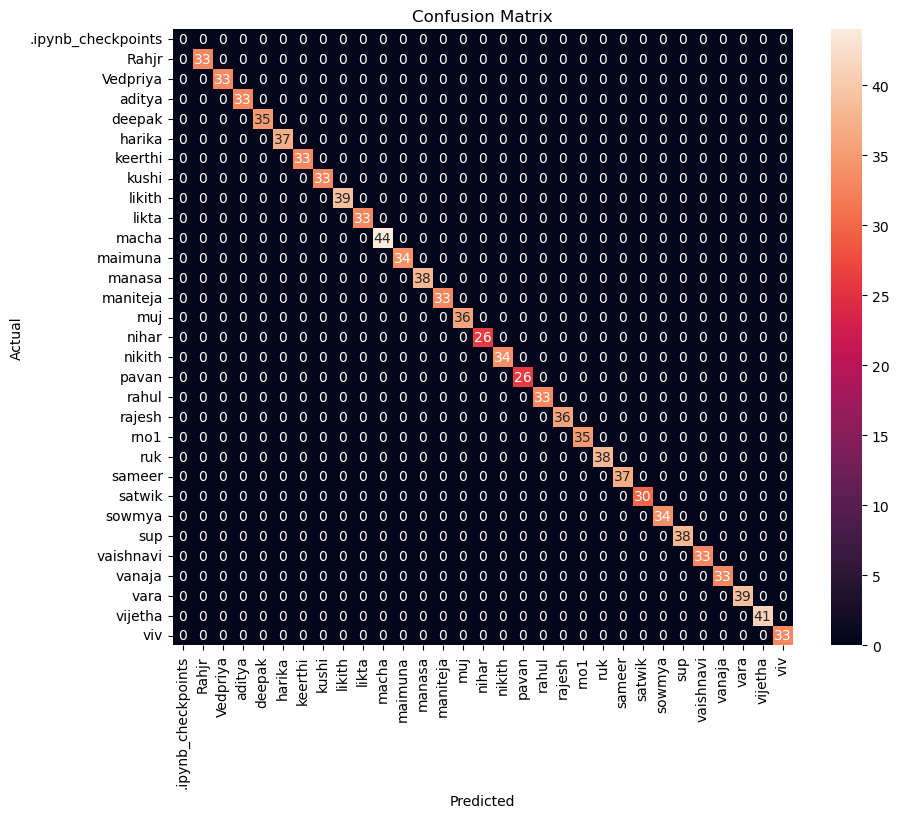

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Get predictions for all test samples
y_pred = [predict_speaker(model, classifier, file) for file in data]
y_true = [speakers[label] for label in labels.numpy()]

# Compute accuracy
#accuracy = accuracy_score(y_true, y_pred)
#print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=speakers)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, xticklabels=speakers, yticklabels=speakers, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [25]:
# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 100.00%


In [9]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="tl1.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("tl1.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "tl1.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-0.3542,  2.5718, -7.3760, -0.5696,  0.6978, -3.4386, -4.2820,
          -1.7312, 10.5612, -0.5004, -7.3022, -3.4142, -5.2186, -0.4747,
          -1.4714, -2.2137, -0.4456,  0.8280,  1.8426, -4.5362, -2.8222,
          -1.6578, -2.3872,  2.9078, -7.4027, -5.8762, -8.0404, -3.4554,
          -5.2343, -4.2856,  0.4758]]])
Predicted Label Index: 8
Predicted Speaker: likith


In [10]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="od1.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("od1.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "od1.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[-10.9164,  -3.7011,  -5.5319,  -3.0234,   6.5313,  -4.1090,  -3.0154,
           -0.0990,  -3.6363,  -5.1630,   5.1188,  -2.0601,  -4.7367,   4.2846,
           -4.6188,  -3.4172,  -4.2106,  -3.8106,   0.8683,  -2.6415,  -2.5940,
           -3.6798,  -0.9622,  -2.4728,  -7.3286,  -0.4036,  -5.6394,  -7.5584,
           -7.0367,  -6.2377,  -2.9046]]])
Predicted Label Index: 4
Predicted Speaker: deepak


In [12]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(filename="vt1.wav", duration=4, sr=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype="int16")
    sd.wait()
    wav.write(filename, sr, audio)
    print("Recording saved.")

# Record and Predict
record_audio("vt1.wav", duration=4)
predicted_speaker = predict_speaker(model, classifier, "vt1.wav")
print(f"Predicted Speaker: {predicted_speaker}")


Recording...
Recording saved.
Embedding Shape: torch.Size([1, 192])
Reshaped Embedding Shape: torch.Size([1, 1, 192])
Model Output Shape: torch.Size([1, 1, 31])
Model Raw Output: tensor([[[ -5.1977,  -3.6614,  -2.9725,  -5.7496,  -7.9739,  -5.2019,   1.0891,
           -8.2120,  -6.7794,   5.9180, -10.5025,   1.2670,  -6.1070,  -1.4493,
           -8.3035,  -4.5658,  -1.7225,  -3.2041,  -7.0467,  -5.1176,  -6.0924,
           -3.8345,  -3.6395,  -7.3069,  -3.7007,  -1.4919,  -2.1325,   8.0805,
            3.4008,   9.7808,  -1.4882]]])
Predicted Label Index: 29
Predicted Speaker: vijetha


In [14]:
import torch

# Save only model weights
torch.save(model.state_dict(), "30speaker_classifier.pth")

print("Model saved successfully as speaker_classifier.pth")


Model saved successfully as speaker_classifier.pth
